In [2]:
from os.path import join
import numpy as np
import torch
import matplotlib.pyplot as plt

from cytoself.datamanager.opencell import DataManagerOpenCell
from cytoself.trainer.cytoselflite_trainer import CytoselfFullTrainer
from cytoself.analysis.analysis_opencell import AnalysisOpenCell
from cytoself.trainer.utils.plot_history import plot_history_cytoself

data_ch = ['pro', 'nuc'] # , 'nucdist', 'label']
# datapath = '/home/ec2-user/cytoself-data'
datapath = 'sample_data'

datamanager = DataManagerOpenCell(datapath, data_ch, fov_col=None)
datamanager.const_dataloader(batch_size=32, label_name_position=1)

Loading pro data...


100%|██████████| 9/9 [00:00<00:00, 14.55it/s]


Loading nuc data...


100%|██████████| 9/9 [00:00<00:00, 154.51it/s]


Loading label data...


100%|██████████| 9/9 [00:00<00:00, 1469.17it/s]


Splitting data...
Computing variance of training data...
Computing variance of validation data...
Computing variance of test data...


In [7]:
datamanager.test_loader.dataset.label

array([['ENSG00000213585', 'VDAC1', 'mitochondria'],
       ['ENSG00000141428', 'C18orf21', 'nucleolus_gc'],
       ['ENSG00000198752', 'CDC42BPB', 'membrane'],
       ['ENSG00000184743', 'ATL3', 'er'],
       ['ENSG00000166598', 'HSP90B1', 'cytoplasmic'],
       ['ENSG00000213585', 'VDAC1', 'mitochondria'],
       ['ENSG00000213585', 'VDAC1', 'mitochondria'],
       ['ENSG00000135404', 'CD63', 'vesicles'],
       ['ENSG00000198752', 'CDC42BPB', 'membrane'],
       ['ENSG00000127526', 'SLC35E1', 'golgi'],
       ['ENSG00000112739', 'PRPF4B', 'chromatin'],
       ['ENSG00000135404', 'CD63', 'vesicles'],
       ['ENSG00000184743', 'ATL3', 'er'],
       ['ENSG00000113569', 'NUP155', 'nuclear_membrane'],
       ['ENSG00000166598', 'HSP90B1', 'cytoplasmic'],
       ['ENSG00000141428', 'C18orf21', 'nucleolus_gc'],
       ['ENSG00000112739', 'PRPF4B', 'chromatin'],
       ['ENSG00000141428', 'C18orf21', 'nucleolus_gc'],
       ['ENSG00000184743', 'ATL3', 'er'],
       ['ENSG00000141428', 'C18

In [11]:
np.var(datamanager.train_loader.dataset.data)

0.01613944

In [18]:
datamanager.train_loader.dataset.data.shape

(1175, 2, 100, 100)

In [3]:
datamanager.train_variance

0.0161394402384758

In [4]:
datamanager.test_variance

0.016104452311992645

In [5]:
1 / 0.0161394402384758

61.96001752378244

In [3]:
model_args = {
    'input_shape': (2, 100, 100),
    'emb_shapes': ((25, 25), (4, 4)),
    'output_shape': (2, 100, 100),
    'fc_output_idx': [2],
    'vq_args': {'num_embeddings': 512, 'embedding_dim': 64},
    'num_class': len(datamanager.unique_labels),
    'fc_input_type': 'vqvec',
}
train_args = {
    'lr': 1e-3,
    'max_epoch': 10,
    'reducelr_patience': 3,
    'reducelr_increment': 0.1,
    'earlystop_patience': 6,
}
trainer = CytoselfFullTrainer(train_args, homepath='demo_output', model_args=model_args)
trainer.fit(datamanager, tensorboard_path='tb_logs')

/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

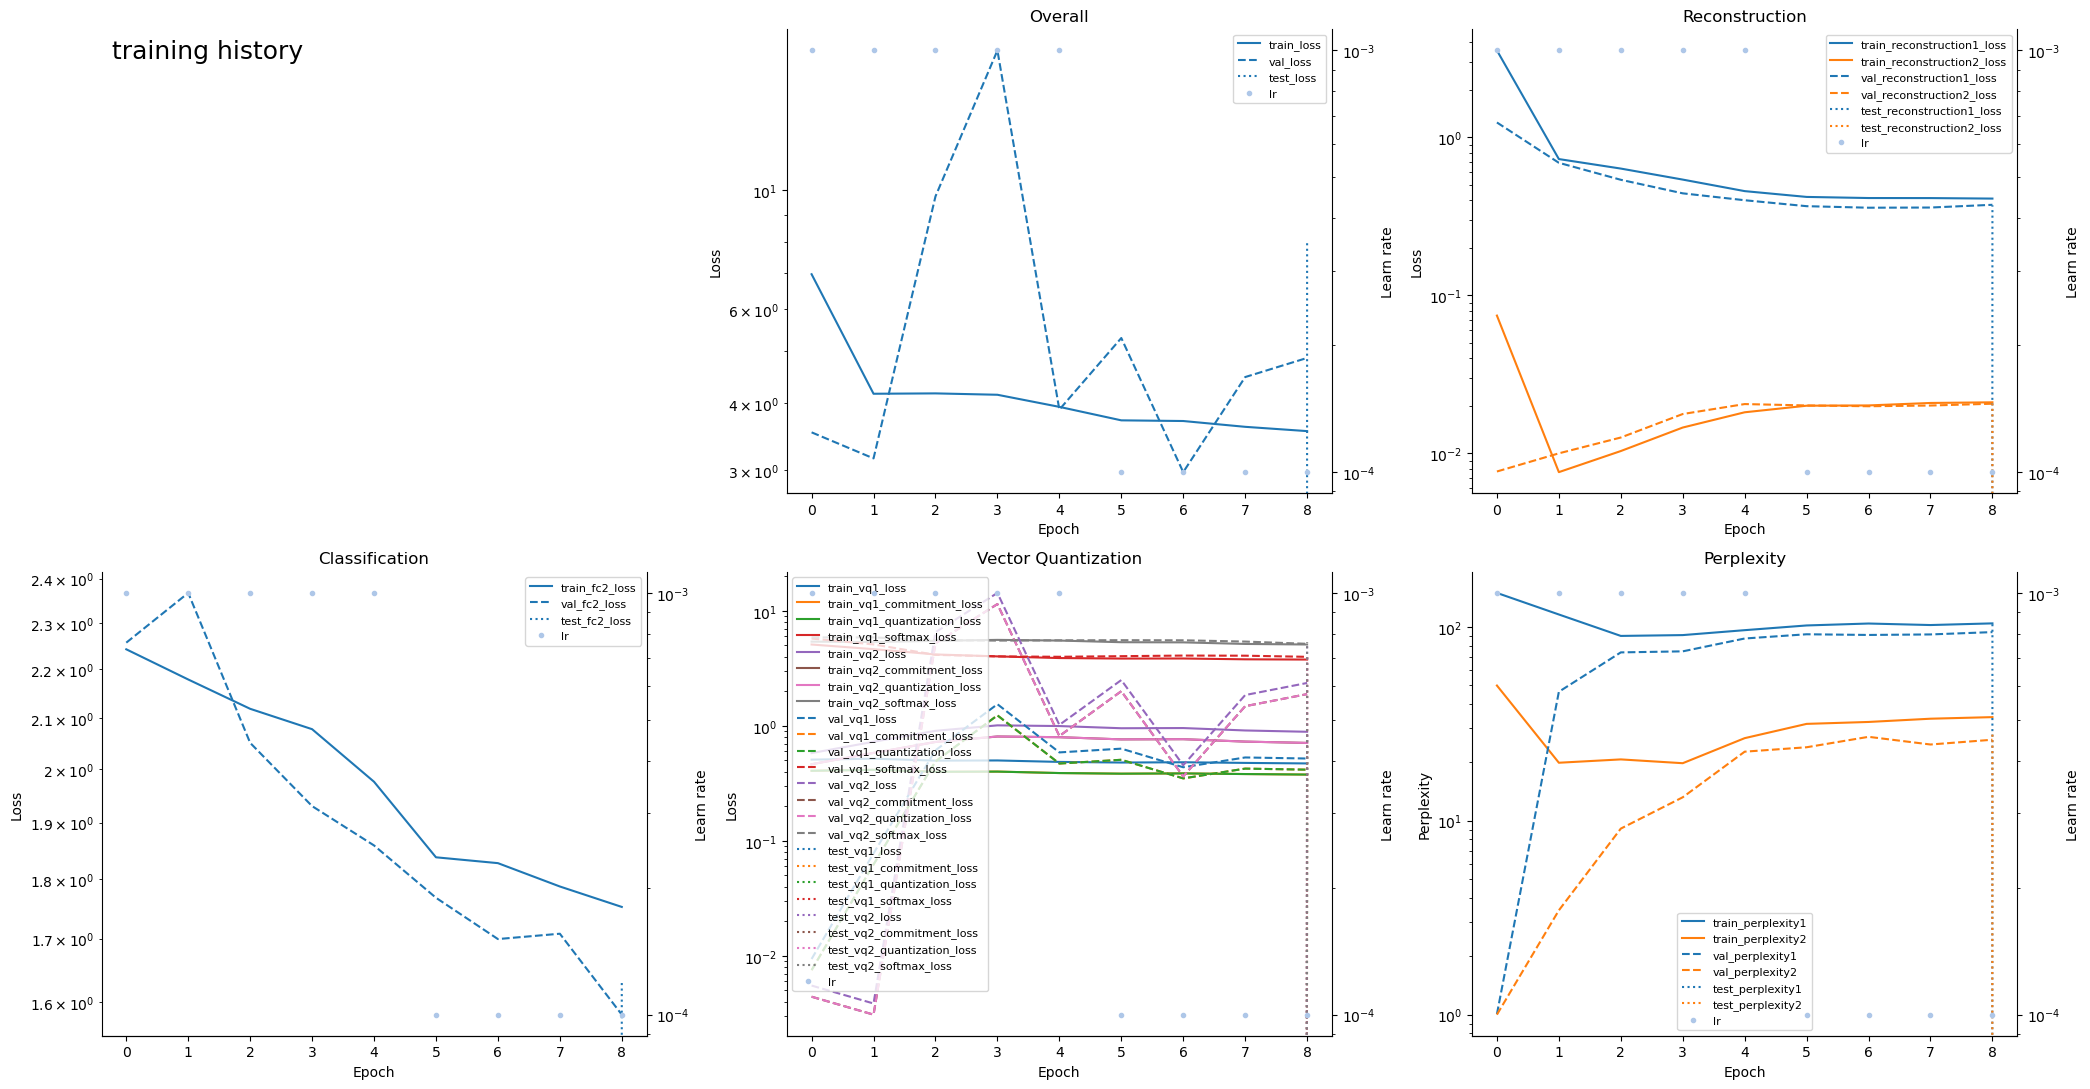

In [22]:
plot_history_cytoself(trainer.history, savepath=trainer.savepath_dict['visualization'])

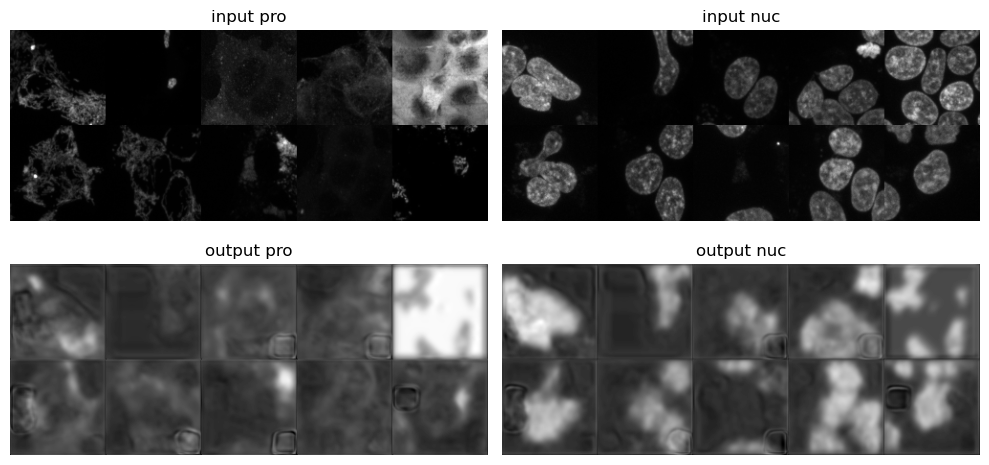

In [23]:
img = next(iter(datamanager.test_loader))['image'].detach().cpu().numpy()
torch.cuda.empty_cache()
reconstructed = trainer.infer_reconstruction(img)
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(img[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(reconstructed[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [4]:
analysis = AnalysisOpenCell(datamanager, trainer)

NameError: name 'trainer' is not defined

Infer: 100%|██████████| 4/4 [00:00<00:00, 15.79it/s]


Computing cell line ID vs vq index...


100%|██████████| 9/9 [00:00<00:00, 6890.97it/s]


Computing self Pearson correlation...


  0%|          | 0/512 [00:00<?, ?it/s]/opt/conda/envs/pytorch/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 512/512 [00:10<00:00, 46.61it/s] 
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


computing clustermaps...


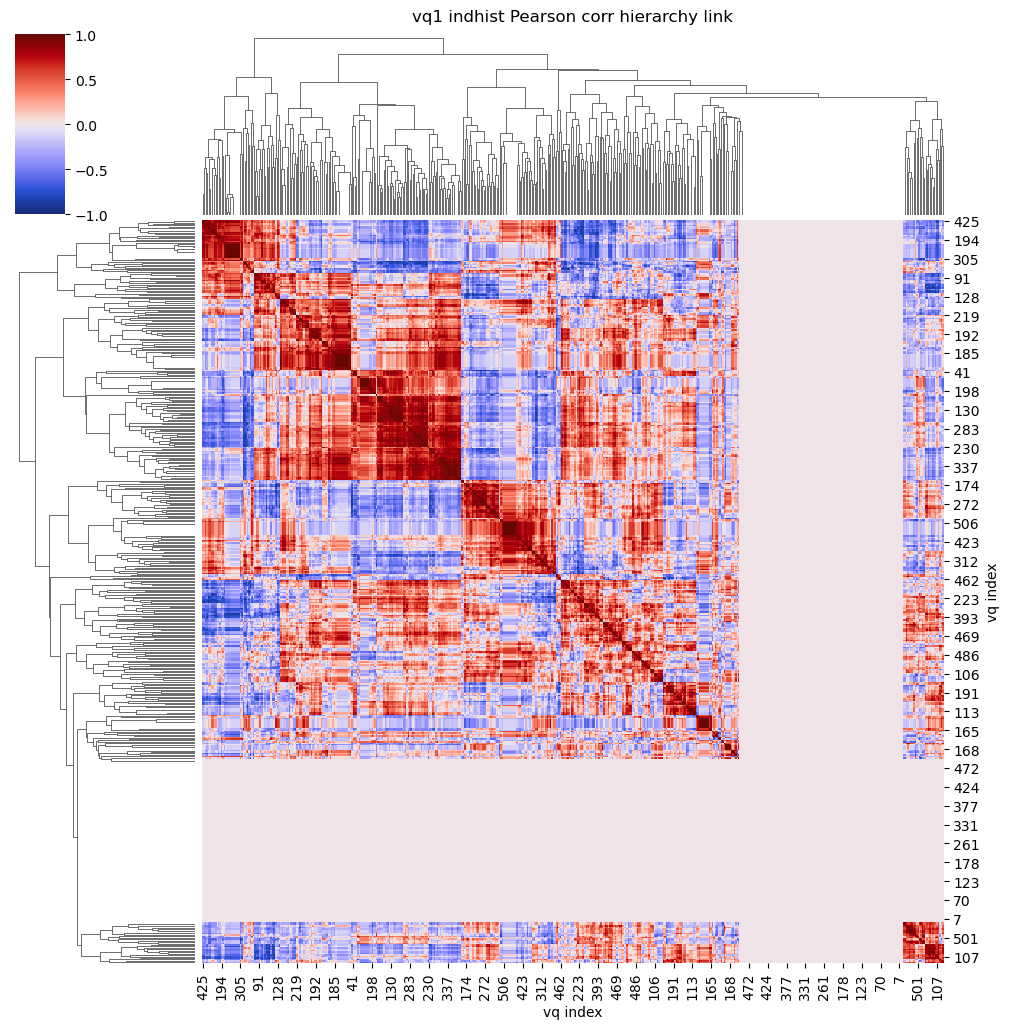

In [25]:
analysis.plot_clustermap(num_workers=4)

Computing embeddings from image...


Infer: 100%|██████████| 4/4 [00:00<00:00, 13.56it/s]

embeddings vqvec2 have been saved at demo_output/embeddings
Computing UMAP coordinates from embeddings...
UMAP( verbose=True)
Sat May 20 02:12:34 2023 Construct fuzzy simplicial set
Sat May 20 02:12:34 2023 Finding Nearest Neighbors
Sat May 20 02:12:34 2023 Finished Nearest Neighbor Search
Sat May 20 02:12:34 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat May 20 02:12:37 2023 Finished embedding


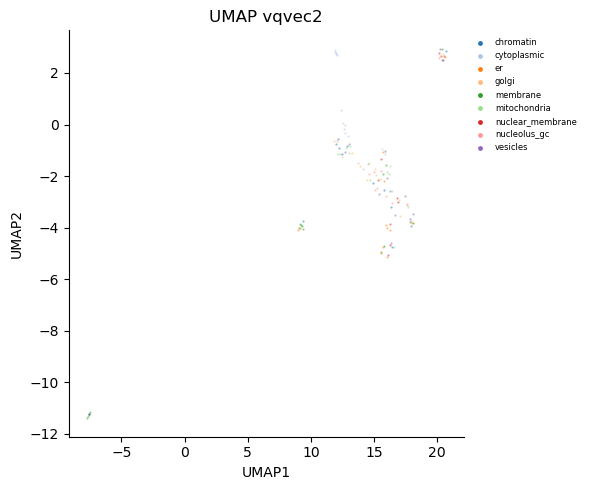

In [17]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(datamanager, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=datamanager.test_loader,
    group_col=2,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

Infer: 100%|██████████| 4/4 [00:00<00:00, 16.24it/s]


Computing cell line ID vs vq index...


100%|██████████| 9/9 [00:00<00:00, 8636.18it/s]


Computing self Pearson correlation...


  0%|          | 0/512 [00:00<?, ?it/s]/opt/conda/envs/pytorch/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 512/512 [00:10<00:00, 48.14it/s] 
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


computing clustermaps...


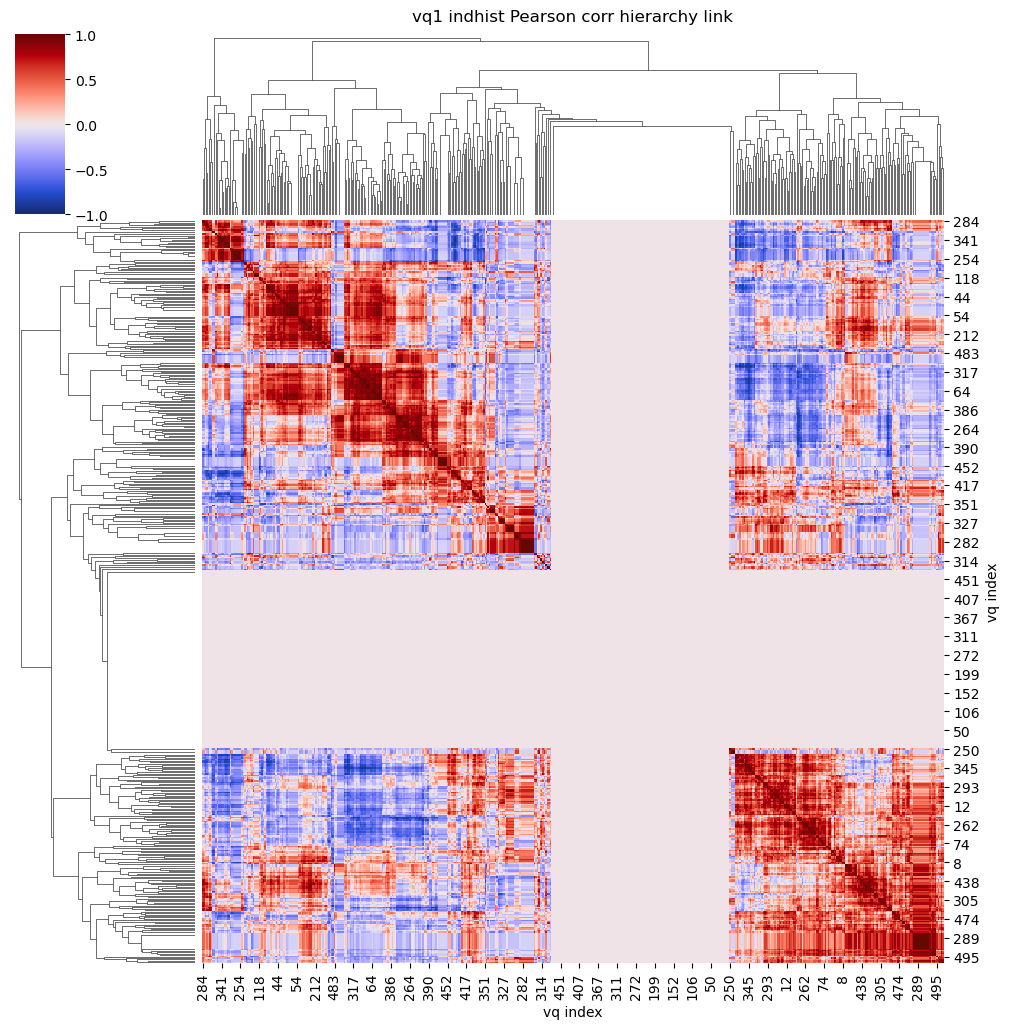

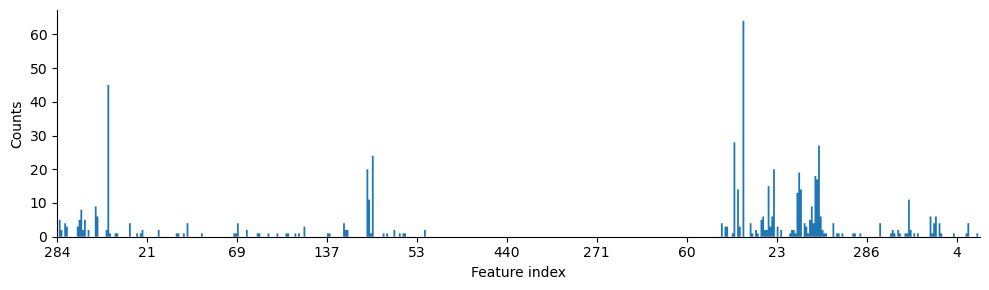

In [18]:
# Compute bi-clustering heatmap
analysis.plot_clustermap(num_workers=4)

# Prepare image data
img = next(iter(datamanager.test_loader))['image'].detach().cpu().numpy()[:1]

# Compute index histogram
vqindhist1 = trainer.infer_embeddings(img, 'vqindhist1')

# Reorder the index histogram according to the bi-clustering heatmap
ft_spectrum = analysis.compute_feature_spectrum(vqindhist1)

# Generate a plot
import numpy as np
import matplotlib.pyplot as plt

x_max = ft_spectrum.shape[1] + 1
x_ticks = np.arange(0, x_max, 50)
fig, ax = plt.subplots(figsize=(10, 3))
ax.stairs(ft_spectrum[0], np.arange(x_max), fill=True)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Feature index')
ax.set_ylabel('Counts')
ax.set_xlim([0, x_max])
ax.set_xticks(x_ticks, analysis.feature_spectrum_indices[x_ticks])
fig.tight_layout()
fig.show()